In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data/routes_new_id.csv')

In [3]:
bad_idx = (data.groupby('new_route_id').count()['time'] < 10).index[(data.groupby('new_route_id').count()['time'] < 10)]

In [4]:
data.drop(data[data['new_route_id'].isin(bad_idx)].index, inplace=True)

In [5]:
target_df = data.groupby('new_route_id').mean()['fraud']
route_ids = list(target_df.index)
route_flag = list(target_df.values)

In [6]:
train_ids, test_ids, train_flag, test_flag = train_test_split(route_ids, route_flag, test_size=0.2, stratify=route_flag, random_state=17)

In [7]:
train_data = data[data['new_route_id'].isin(train_ids)]
test_data = data[data['new_route_id'].isin(test_ids)]

In [8]:
X_columns = ['gps_delta',
       'gps_distance', 'gps_speed', 'gps_accel', 'tm_delta', 'tm_distance',
       'tm_speed', 'tm_accel', 'diff_time', 'diff_distance', 'diff_speed',
       'diff_accel', 'ac_x', 'ac_y', 'ac_z', 'ac_lat', 'ac_lon',
       'ac_delta', 'ac_distance', 'ac_speed', 'ac_accel']

In [9]:
scaler = StandardScaler()
scaler.fit(train_data[X_columns])

StandardScaler()

In [10]:
class DatasetFraud(Dataset):
    def __init__(self, data, scaler=None):
        self.data = data.copy(deep=True)
        self.length = self.data['new_route_id'].nunique()
        self.routes = self.data['new_route_id'].unique()
        self.scaler = scaler
        if self.scaler:
            self.data.loc[:, X_columns] = self.scaler.transform(self.data.loc[:, X_columns])
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        route_id = self.routes[idx]
        route_data = self.data[self.data['new_route_id'] == route_id]
        
        X = route_data[X_columns].values
        X = torch.tensor(X, dtype=torch.float32)
        
        target = torch.tensor(route_data.loc[:, 'fraud'].values[0] + 1)
        return X, target

In [11]:
train_dataset = DatasetFraud(train_data, scaler)
test_dataset = DatasetFraud(test_data, scaler)

In [12]:
class ModelGPS(nn.Module):
    def __init__(self, in_features, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(in_features, hidden_dim, batch_first=True, dropout=0.1)
        self.output_linear = nn.Linear(hidden_dim, 3)
        
    def forward(self, ride):
        output, _ = self.lstm(ride)
        output = output[:, -1, :]
        output = self.output_linear(output)
        return output

In [13]:
model = torch.load('models/lstm_model_normalized.torch')

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [17]:
device = torch.device('cuda')
model.to(device)

ModelGPS(
  (lstm): LSTM(21, 256, batch_first=True, dropout=0.1)
  (output_linear): Linear(in_features=256, out_features=3, bias=True)
)

In [19]:
model.lstm.eval()

LSTM(21, 256, batch_first=True, dropout=0.1)

In [20]:
embs = []
y_true = []
for X, target in tqdm(test_dataloader):
    X = X.to(device)
    y_true.append(target.item())
    with torch.no_grad():
        embed = model.lstm(X)
        embs.append(embed)

100%|████████████████████████████████████████████████████████████████████████████████| 617/617 [00:49<00:00, 12.58it/s]


In [28]:
embs = [each[0][:, -1, :].flatten() for each in embs]

In [35]:
embs = [each.cpu().numpy() for each in embs]

In [41]:
from sklearn.decomposition import PCA

In [42]:
pca = PCA(n_components=2)
pca.fit(embs)

PCA(n_components=2)

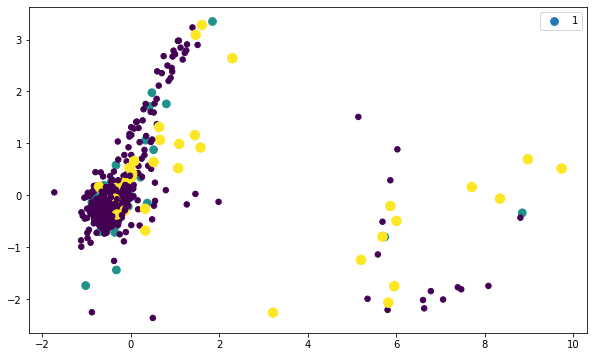

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(pca.transform(embs)[:, 0], pca.transform(embs)[:, 1], c=y_true, s=(np.array(y_true) + 1) * 30)
plt.legend(y_true)
# желтые = -1, синие = 0, фиолетовые = -1.

In [38]:
len(embs)

617

In [40]:
len(y_true)

617

In [27]:
embs[0][0][:, -1, :].flatten().shape

torch.Size([256])

In [38]:
class ModelGPS(nn.Module):
    def __init__(self, in_features, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(in_features, hidden_dim, batch_first=True, dropout=0.1, num_layers=3)
        self.output_linear = nn.Linear(hidden_dim, 3)
        
    def forward(self, ride):
        output, _ = self.lstm(ride)
        output = output[:, -1, :]
        output = self.output_linear(output)
        return output

In [39]:
model = ModelGPS(21, 256)
weights = 1 / data.groupby('new_route_id').mean()['fraud'].value_counts(normalize=True).values
weights / weights.sum()
loss_fn = nn.CrossEntropyLoss(weight=1 / torch.tensor(weights, dtype=torch.float32))
opt = optim.Adam(model.parameters(), lr=1e-4)

In [40]:
from tqdm.notebook import tqdm

In [42]:
loss_history = []
device = torch.device('cuda')
model.to(device)
num_epochs = 30
for ep in tqdm(range(num_epochs)):
    loss_epoch = []
    model.train()
    # for i in tqdm(np.random.choice(len(train_dataset), size=500)):
        # X, target = train_dataset[i]
    for X, target in tqdm(train_dataloader):
        X = X.to(device)
        
        pred = model(X)
        loss = loss_fn(pred.cpu(), target)

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_epoch.append(loss.cpu().detach().item())

    model.eval()
    y_pred = []
    y_true = []
    loss_val = []
    for X, target in tqdm(test_dataloader):
        X = X.to(device)
        y_true.append(target.item())
        with torch.no_grad():
            pred = model(X)
            val_loss = loss_fn(pred.cpu(), target)
            loss_val.append(val_loss)
        y_pred.append(pred.argmax().cpu().item())
    f1 = f1_score(y_true, y_pred, average='weighted')
    prec = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    print(f'EP {ep:2} LOSS: {round(np.mean(loss_epoch), 2)} LOSS_VAL: {round(np.mean(loss_val), 2)} F1: {f1:.3f} PREC: {prec:.3f} REC: {recall:.3f} ACC: {accuracy:.3f}')
    loss_history.append(np.mean(loss_epoch))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/2468 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

EP  0 LOSS: 0.26 LOSS_VAL: 0.9599999785423279 F1: 0.740 PREC: 0.675 REC: 0.820 ACC: 0.820


  0%|          | 0/2468 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

EP  1 LOSS: 0.27 LOSS_VAL: 0.8899999856948853 F1: 0.741 PREC: 0.675 REC: 0.822 ACC: 0.822


  0%|          | 0/2468 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

EP  2 LOSS: 0.29 LOSS_VAL: 0.9700000286102295 F1: 0.741 PREC: 0.675 REC: 0.822 ACC: 0.822


  0%|          | 0/2468 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

EP  3 LOSS: 0.29 LOSS_VAL: 0.9200000166893005 F1: 0.738 PREC: 0.674 REC: 0.815 ACC: 0.815


  0%|          | 0/2468 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

EP  4 LOSS: 0.31 LOSS_VAL: 0.9200000166893005 F1: 0.741 PREC: 0.675 REC: 0.822 ACC: 0.822


  0%|          | 0/2468 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

EP  5 LOSS: 0.3 LOSS_VAL: 0.9399999976158142 F1: 0.740 PREC: 0.675 REC: 0.820 ACC: 0.820


  0%|          | 0/2468 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

EP  6 LOSS: 0.29 LOSS_VAL: 0.8799999952316284 F1: 0.740 PREC: 0.675 REC: 0.820 ACC: 0.820


  0%|          | 0/2468 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

EP  7 LOSS: 0.32 LOSS_VAL: 0.8799999952316284 F1: 0.741 PREC: 0.675 REC: 0.822 ACC: 0.822


  0%|          | 0/2468 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [43]:
torch.save(model, 'models/lstm_model_normalized_3_layers_.torch')

In [ ]:
class ModelGPS(nn.Module):
    def __init__(self, in_features, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(in_features, hidden_dim)
        self.output_linear = nn.Linear(hidden_dim, 3)
        
    def forward(self, ride):
        output, _ = self.lstm(ride.view(len(ride), 1, -1).to(device))
        output = output[-1].flatten()
        output = self.output_linear(output)
        return output

In [123]:
f1_score(y_true, y_pred, average='weighted')

0.7630480131324004

In [129]:
precision_score(y_true, y_pred, average='weighted')

0.7935254536023447

In [128]:
recall_score(y_true, y_pred, average='weighted')

0.8249594813614263

In [133]:
right_cnt = 0
wrong_cnt = 0
for i in range(len(y_true)):
    if y_true[i] == y_pred[i] == 2:
        right_cnt += 1
    elif y_pred[i] != y_true[i] == 2:
        wrong_cnt += 1

In [134]:
right_cnt

6

In [135]:
wrong_cnt

28

In [132]:
y_pred

[0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [130]:
accuracy_score(y_true, y_pred)

0.8249594813614263

In [120]:
pred

tensor([ 2.3494,  0.0700, -3.0100], device='cuda:0')

In [113]:
y_pred

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [112]:
y_true

[tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tenso

# Data Preprocessing

In [67]:
data = pd.read_csv('data/matched_routs.csv')

In [84]:
new_data = []
columns_to_zero = ['gps_delta', 'gps_distance', 'gps_speed', 'tm_delta', 'tm_distance', 'tm_speed', 'tm_accel', 'diff_time', 
                   'diff_distance', 'diff_speed', 'ac_delta', 'ac_distance', 'ac_speed', 'delta']
for route_id in tqdm(data['route_id'].unique()):
    route_data_ = data[data['route_id'] == route_id]
    drivers = route_data_['driver_hash'].unique()
    for each in drivers:
        route_data = route_data_[route_data_['driver_hash'] == each]
        if route_data.shape[0] < 10:
            continue
        route_data['gps_time'] = pd.to_datetime(route_data['gps_time'])
        route_data.sort_values('gps_time', inplace=True)
        route_data.reset_index(drop=True, inplace=True)
        route_data['delta'] = pd.to_datetime(route_data['gps_time']).diff().dt.total_seconds().fillna(0)
        route_data['num'] = np.where((route_data['delta'] > 5 * 60) | (route_data.index == route_data.index[0]), route_data.index, np.nan)
        route_data.loc[~route_data['num'].isna(), columns_to_zero] = 0
        route_data['num'] = route_data['num'].ffill()
        route_data['new_route_id'] = str(route_id) + '_' + route_data['num'].astype(str) + '_' + str(each)
        new_data.append(route_data)
        assert route_data['fraud'].mean() in [0, 1, -1]
    # data.loc[route_data.index, 'new_route_id'] = route_data['new_route_id']

100%|██████████████████████████████████████████████████████████████████████████████| 1068/1068 [00:31<00:00, 33.43it/s]


In [85]:
concat_df = pd.concat(new_data)

In [90]:
concat_df.groupby('new_route_id').mean()['fraud'].unique()

array([ 0., -1.,  1.])

In [91]:
concat_df.to_csv('data/routes_new_id.csv', index=False)

In [175]:
data.drop(['delta'], axis=1, inplace=True)

In [178]:
data.to_csv('data/routes_new_id.csv', index=False)